### 프레임 t→t+1에서 22개 관절이 평균적으로 얼마나 움직였는지

- scalar_speed_mean: (프레임, 22관절, 3D) 포지션 시퀀스에서 '이 동작이 평균적으로 얼마나 빠른지'. 전체 관절 움직임을 반영
    - 전체 시퀀스에서 매 초마다 22개 관절이 평균적으로 얼마나 움직엿는지의 평균 속도.
    - Pelvis만을 측정하지 않은 이유는 정지 동작도 존재하기 때문.
        - 1) 프레임 간 차분
        - 2) 각 관절의 이동거리를 L2로 계산
        - 3) 22개 관절의 평균. 프레임당 평균 이동거리
        - 4) 전체 프레임에 대한 평균 -> 프레임당 평균 이동거리
        - 5) fps를 곱해서 초당 평균 이동거리로 변환


In [2]:
# 1. 라이브러리 임포트
import os
import numpy as np
import matplotlib.pyplot as plt

In [64]:
# 2. 파일 경로 설정
npy_path = "C:/Users/Velab/Desktop/HumanML3D_Org/new_joints/002110.npy" # 파일 경로
out_dir = "C:/Users/Velab/Desktop/HumanML3D_Org/" # 저장 폴더
os.makedirs(out_dir, exist_ok=True)

In [65]:
# 3. 파일 로드
pos = np.load(npy_path)  # (T, J, 3)
assert pos.ndim == 3 and pos.shape[-1] == 3, f"Expected (T,J,3), got {pos.shape}"
T, J, _ = pos.shape
print("Loaded:", pos.shape, pos.dtype)

Loaded: (199, 22, 3) float32


In [ ]:
# 4. 1) 프레임별/관절별 포지션 변화량(L2) 계산

# 프레임 간 포지션 변화량(차분). dpos[t, j, :] = pos[t+1, j, :] - pos[t, j, :]
dpos = np.diff(pos, axis=0)                    # (T-1, J, 3)

# 각 관절별 변화량을 L2로 계산
delta_per_joint = np.linalg.norm(dpos, axis=2) # (T-1, J)  <-- L2

# 4. 2) 모든 관절 평균치로 프레임별 변화량 시계열. 22개 관절의 L2 변화량 평균
delta_mean = delta_per_joint.mean(axis=1)      # (T-1,)
cum_delta_mean = np.cumsum(delta_mean)         # (T-1,)

# ===== 스칼라 평균 속도(A) =====
fps = 20.0
scalar_speed_mean = float(delta_mean.mean() * fps)  # units/s
frames = np.arange(1, T)  # (T-1,) # x축(차분이라 1..T-1 프레임에 대응)
txt = f"scalar_speed_mean = {scalar_speed_mean:.6f} units/s" # 보조: 그래프에 쓸 텍스트

print("delta_per_joint:", delta_per_joint.shape)
print("delta_mean:", delta_mean.shape)
print(scalar_speed_mean)

delta_per_joint: (198, 22)
delta_mean: (198,)
0.6816721707582474


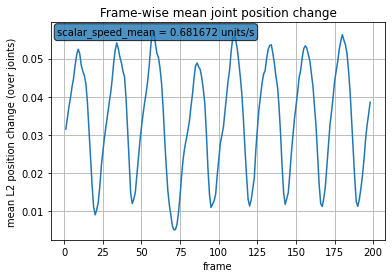

In [67]:
# ===== 1) 프레임별 변화량 플롯 저장 =====
plt.figure()
plt.plot(frames, delta_mean)
plt.xlabel("frame")
plt.ylabel("mean L2 position change (over joints)")
plt.title("Frame-wise mean joint position change")
plt.grid(True)

# 그래프 안쪽에 텍스트 박스
plt.gca().text(
    0.02, 0.98, txt,
    transform=plt.gca().transAxes,
    va="top", ha="left",
    bbox=dict(boxstyle="round", alpha=0.8)
)

save1 = os.path.join(out_dir, "mean_joint_delta.png")
plt.savefig(save1, dpi=200, bbox_inches="tight")
plt.show()
plt.close()

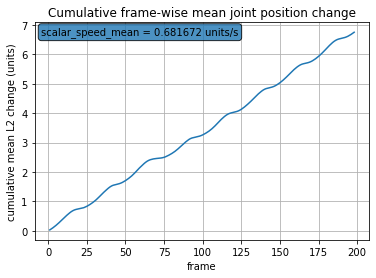

In [68]:
# ===== 2) 프레임별 변화량 누적(거리 누적) 플롯 저장 =====
cum_delta_mean = np.cumsum(delta_mean)  # (T-1,)

plt.figure()
plt.plot(frames, cum_delta_mean)
plt.xlabel("frame")
plt.ylabel("cumulative mean L2 change (units)")
plt.title("Cumulative frame-wise mean joint position change")
plt.grid(True)

plt.gca().text(
    0.02, 0.98, txt,
    transform=plt.gca().transAxes,
    va="top", ha="left",
    bbox=dict(boxstyle="round", alpha=0.8)
)

save2 = os.path.join(out_dir, "cumulative_mean_joint_delta.png")
plt.savefig(save2, dpi=200, bbox_inches="tight")
plt.show()
plt.close()

## 폴더 단위 코드 실행

In [ ]:
# ===== 폴더 단위 실행 =====
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

input_folder = Path("C:/Users/Velab/Desktop/HumanML3D_Org/new_joints")
output_folder = Path("C:/Users/Velab/Desktop/HumanML3D_Org/velocity_pos_vis")
output_folder.mkdir(exist_ok=True)

In [ ]:
fps = 20  # FPS 설정

npy_files = sorted(input_folder.glob("*.npy"))
total_files = len(npy_files)

# 이미 처리된 파일 확인 (두 개의 PNG 파일이 모두 있는 경우)
existing_mean = {f.stem.replace('_mean_joint_delta', '') for f in output_folder.glob("*_mean_joint_delta.png")}
existing_cumulative = {f.stem.replace('_cumulative_delta', '') for f in output_folder.glob("*_cumulative_delta.png")}
already_processed = existing_mean & existing_cumulative

# 처리할 파일 필터링
files_to_process = [f for f in npy_files if f.stem not in already_processed]

print(f"Total files: {total_files}")
print(f"Already processed: {len(already_processed)}")
print(f"To process: {len(files_to_process)}\n")

# 에러 로그
error_log = []

for idx, npy_file in enumerate(files_to_process, 1):
    sys.stdout.write(f"\rProcessing [{idx}/{len(files_to_process)}]: {npy_file.name}")
    sys.stdout.flush()
    
    try:
        # 파일 로드
        pos = np.load(str(npy_file))
        
        # Shape 검증
        if pos.ndim != 3 or pos.shape[-1] != 3:
            error_log.append(f"{npy_file.name}: Invalid shape {pos.shape}")
            continue
            
        T, J, _ = pos.shape
        
        # 변화량 계산
        dpos = np.diff(pos, axis=0)
        delta_per_joint = np.linalg.norm(dpos, axis=2)
        delta_mean = delta_per_joint.mean(axis=1)
        
        # 스칼라 평균 속도
        scalar_speed_mean = float(delta_mean.mean() * fps)
        frames = np.arange(1, T)
        txt = f"scalar_speed_mean = {scalar_speed_mean:.6f} units/s"
        
        # 1) 프레임별 변화량 플롯
        plt.figure(figsize=(10, 6))
        plt.plot(frames, delta_mean)
        plt.xlabel("frame")
        plt.ylabel("mean L2 position change (over joints)")
        plt.title(f"Frame-wise mean joint position change - {npy_file.stem}")
        plt.grid(True)
        plt.gca().text(
            0.02, 0.98, txt,
            transform=plt.gca().transAxes,
            va="top", ha="left",
            bbox=dict(boxstyle="round", alpha=0.8)
        )
        save1 = output_folder / f"{npy_file.stem}_mean_joint_delta.png"
        plt.savefig(save1, dpi=150, bbox_inches="tight")
        plt.close()
        
        # 2) 누적 변화량 플롯
        cum_delta_mean = np.cumsum(delta_mean)
        plt.figure(figsize=(10, 6))
        plt.plot(frames, cum_delta_mean)
        plt.xlabel("frame")
        plt.ylabel("cumulative mean L2 change (units)")
        plt.title(f"Cumulative mean joint position change - {npy_file.stem}")
        plt.grid(True)
        plt.gca().text(
            0.02, 0.98, txt,
            transform=plt.gca().transAxes,
            va="top", ha="left",
            bbox=dict(boxstyle="round", alpha=0.8)
        )
        save2 = output_folder / f"{npy_file.stem}_cumulative_delta.png"
        plt.savefig(save2, dpi=150, bbox_inches="tight")
        plt.close()
        
    except Exception as e:
        error_log.append(f"{npy_file.name}: {type(e).__name__} - {str(e)}")
        plt.close('all')
        continue

print(f"\n\nAll processed. Output: {output_folder}")

# 에러 로그 저장
if error_log:
    print(f"\n\n=== Errors ({len(error_log)} files) ===")
    for err in error_log:
        print(err)
    
    log_file = output_folder / "error_log.txt"
    with open(log_file, 'w') as f:
        f.write('\n'.join(error_log))
    print(f"\nError log saved to: {log_file}")

Total files: 29228
Already processed: 17344
To process: 11884

Processing [11884/11884]: M014615.npy

All processed. Output: C:\Users\Velab\Desktop\HumanML3D_Org\velocity_pos_vis


=== Errors (4 files) ===
000990.npy: Invalid shape (22, 3)
005836.npy: Invalid shape (22, 3)
M000990.npy: Invalid shape (22, 3)
M005836.npy: Invalid shape (22, 3)

Error log saved to: C:\Users\Velab\Desktop\HumanML3D_Org\velocity_pos_vis\error_log.txt
